In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [2]:
df = pd.read_csv('./data/cleaned/cleaned_data.csv')
df.head()

,Date,Fulfilment,ship-service-level,Category,Size,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B,fulfilled-by
0,2022-04-30,Merchant,Standard,T-shirt,S,On the Way,0,647.62,MUMBAI,MAHARASHTRA,400081,False,Easy Ship
1,2022-04-30,Merchant,Standard,Shirt,3XL,Shipped,1,406.00,BENGALURU,KARNATAKA,560085,False,Easy Ship
2,2022-04-30,Amazon,Expedited,Shirt,XL,Shipped,1,329.00,NAVI MUMBAI,MAHARASHTRA,410210,True,Other methods
3,2022-04-30,Merchant,Standard,Blazzer,L,On the Way,0,753.33,PUDUCHERRY,PUDUCHERRY,605008,False,Easy Ship
4,2022-04-30,Amazon,Expedited,Trousers,3XL,Shipped,1,574.00,CHENNAI,TAMIL NADU,600073,False,Other methods


Central question: **How can we optimize the fulfillment process to reduce operational costs while simultaneously improving customer satisfaction and delivery speed?**

/tmp/ipykernel_449059/1255628969.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Cancellation Rate', x='Category', data=cancellation_data, palette='coolwarm')


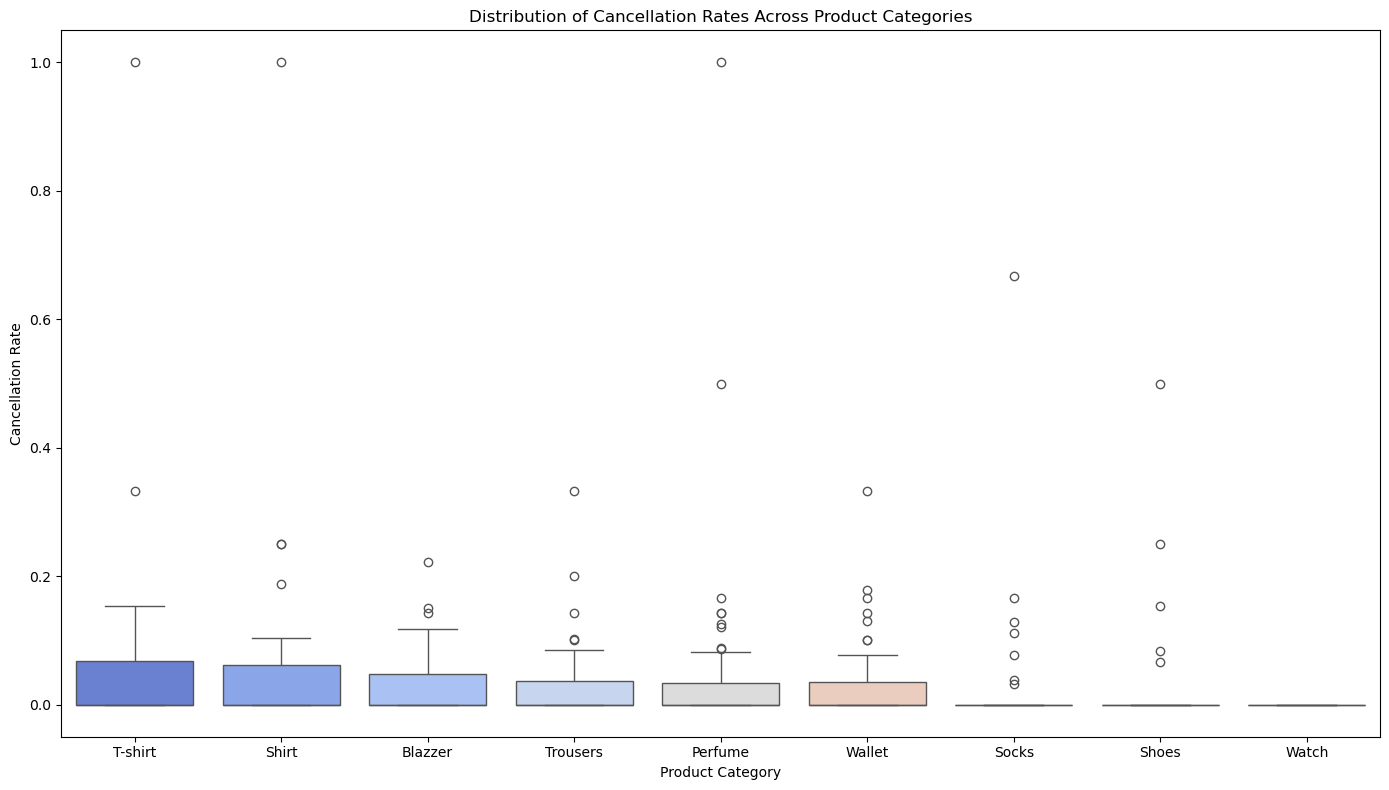

In [11]:
total_orders_by_region = df.groupby(['ship-state', 'Category', 'Fulfilment'])['Qty'].count().reset_index(name='Total Orders')

cancellations_by_region = df[df['Courier Status'] == 'Cancelled'].groupby(['ship-state', 'Category', 'Fulfilment'])['Qty'].count().reset_index(name='Cancelled Orders')

cancellation_data = pd.merge(total_orders_by_region, cancellations_by_region, on=['ship-state', 'Category', 'Fulfilment'], how='left')
cancellation_data['Cancelled Orders'] = cancellation_data['Cancelled Orders'].fillna(0)
cancellation_data['Cancellation Rate'] = cancellation_data['Cancelled Orders'] / cancellation_data['Total Orders']

total_orders_by_category = cancellation_data.groupby('Category')['Total Orders'].sum().reset_index()

sorted_categories = total_orders_by_category.sort_values(by='Total Orders', ascending=False)['Category']

cancellation_data['Category'] = pd.Categorical(cancellation_data['Category'], categories=sorted_categories, ordered=True)
cancellation_data = cancellation_data.sort_values('Category')

plt.figure(figsize=(14, 8))
sns.boxplot(y='Cancellation Rate', x='Category', data=cancellation_data, palette='coolwarm')
plt.title('Distribution of Cancellation Rates Across Product Categories')
plt.ylabel('Cancellation Rate')
plt.xlabel('Product Category')
plt.tight_layout()
plt.show()

- Categories like Perfume and Shirt have high median cancellation rates, indicating frequent customer dissatisfaction. Categories such as Socks and Blazzer show significant variability in cancellation rates, suggesting inconsistent customer experiences.

- Address issues in high-risk categories and investigate variability within problematic categories to reduce cancellations.

/tmp/ipykernel_449059/533384611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Amount', y='ship-state', data=top_sales_by_region, palette='viridis')


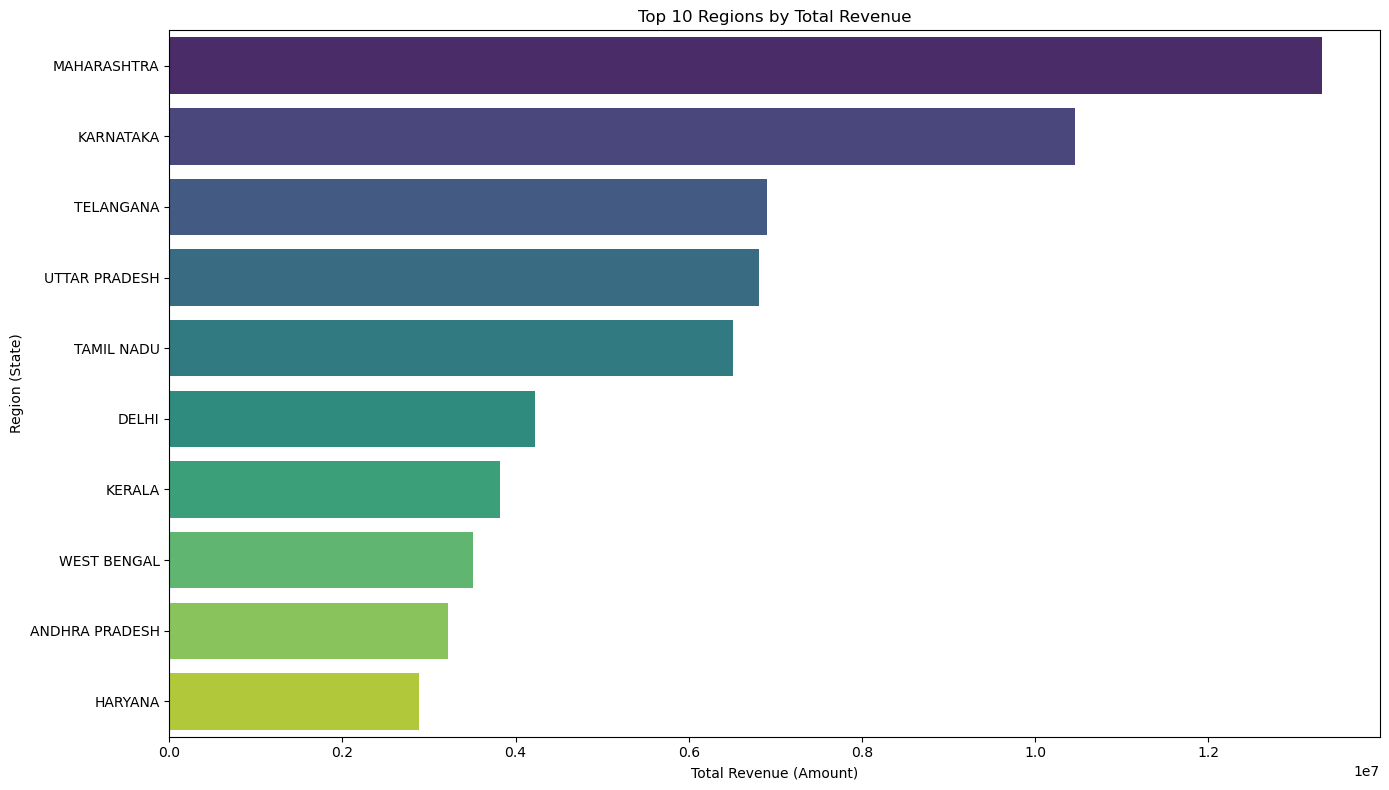

In [5]:
sales_by_region_category = df.groupby(['ship-state', 'Category'])[['Qty', 'Amount']].sum().reset_index()

top_sales_by_region = sales_by_region_category.groupby('ship-state')[['Qty', 'Amount']].sum().sort_values(by='Amount', ascending=False).head(10)
top_sales_by_category = sales_by_region_category.groupby('Category')[['Qty', 'Amount']].sum().sort_values(by='Amount', ascending=False).head(10)

top_sales_by_region.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
sns.barplot(x='Amount', y='ship-state', data=top_sales_by_region, palette='viridis')
plt.title('Top 10 Regions by Total Revenue')
plt.xlabel('Total Revenue (Amount)')
plt.ylabel('Region (State)')
plt.tight_layout()
plt.show()

**Dominant Regions**

- Maharashtra and Karnataka are the leading states in terms of revenue, indicating high demand and market penetration in these areas.

- Other states like Delhi and Tamil Nadu also contribute significantly, though their total revenue is notably lower compared to the top two regions.

**Concentration of Revenue**

- A substantial portion of the business's revenue is concentrated in a few states, suggesting that business strategies should focus on maintaining and expanding operations in these high-revenue areas.

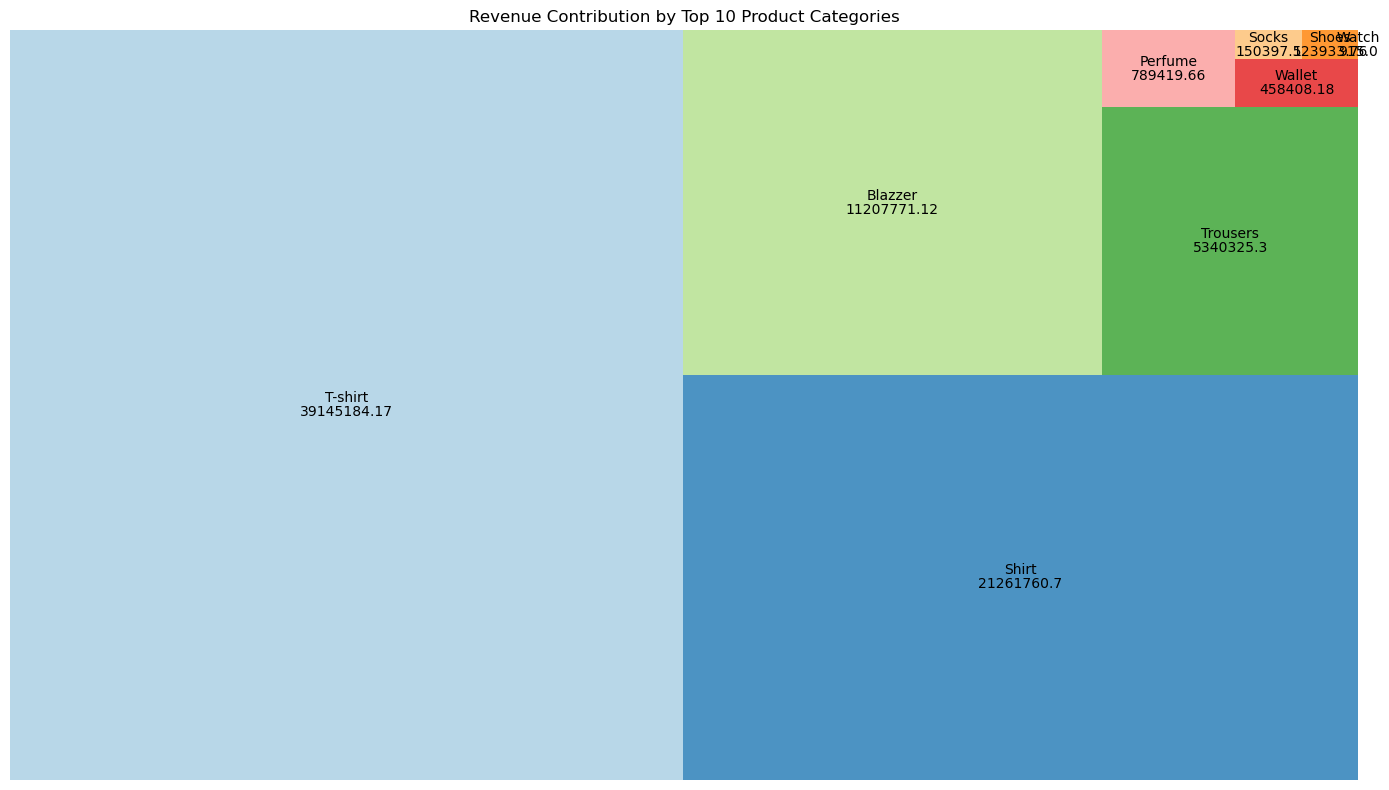

In [6]:
plt.figure(figsize=(14, 8))
squarify.plot(sizes=top_sales_by_category['Amount'], label=top_sales_by_category.index, 
              value=top_sales_by_category['Amount'], alpha=.8, color=sns.color_palette('Paired', 10))
plt.title('Revenue Contribution by Top 10 Product Categories')
plt.axis('off')
plt.tight_layout()
plt.show()

**Top Revenue-Generating Categories:**

- T-shirt leads by a large margin in revenue contribution, making it a critical category for the business.
    
- Shirt and Blazzer also contribute significantly but are far behind "T-shirt" in total revenue.

**Importance of Apparel:**

- The majority of top revenue categories are apparel-related (T-shirt, Shirt, Blazzer, Trousers), indicating a strong market presence in this segment.

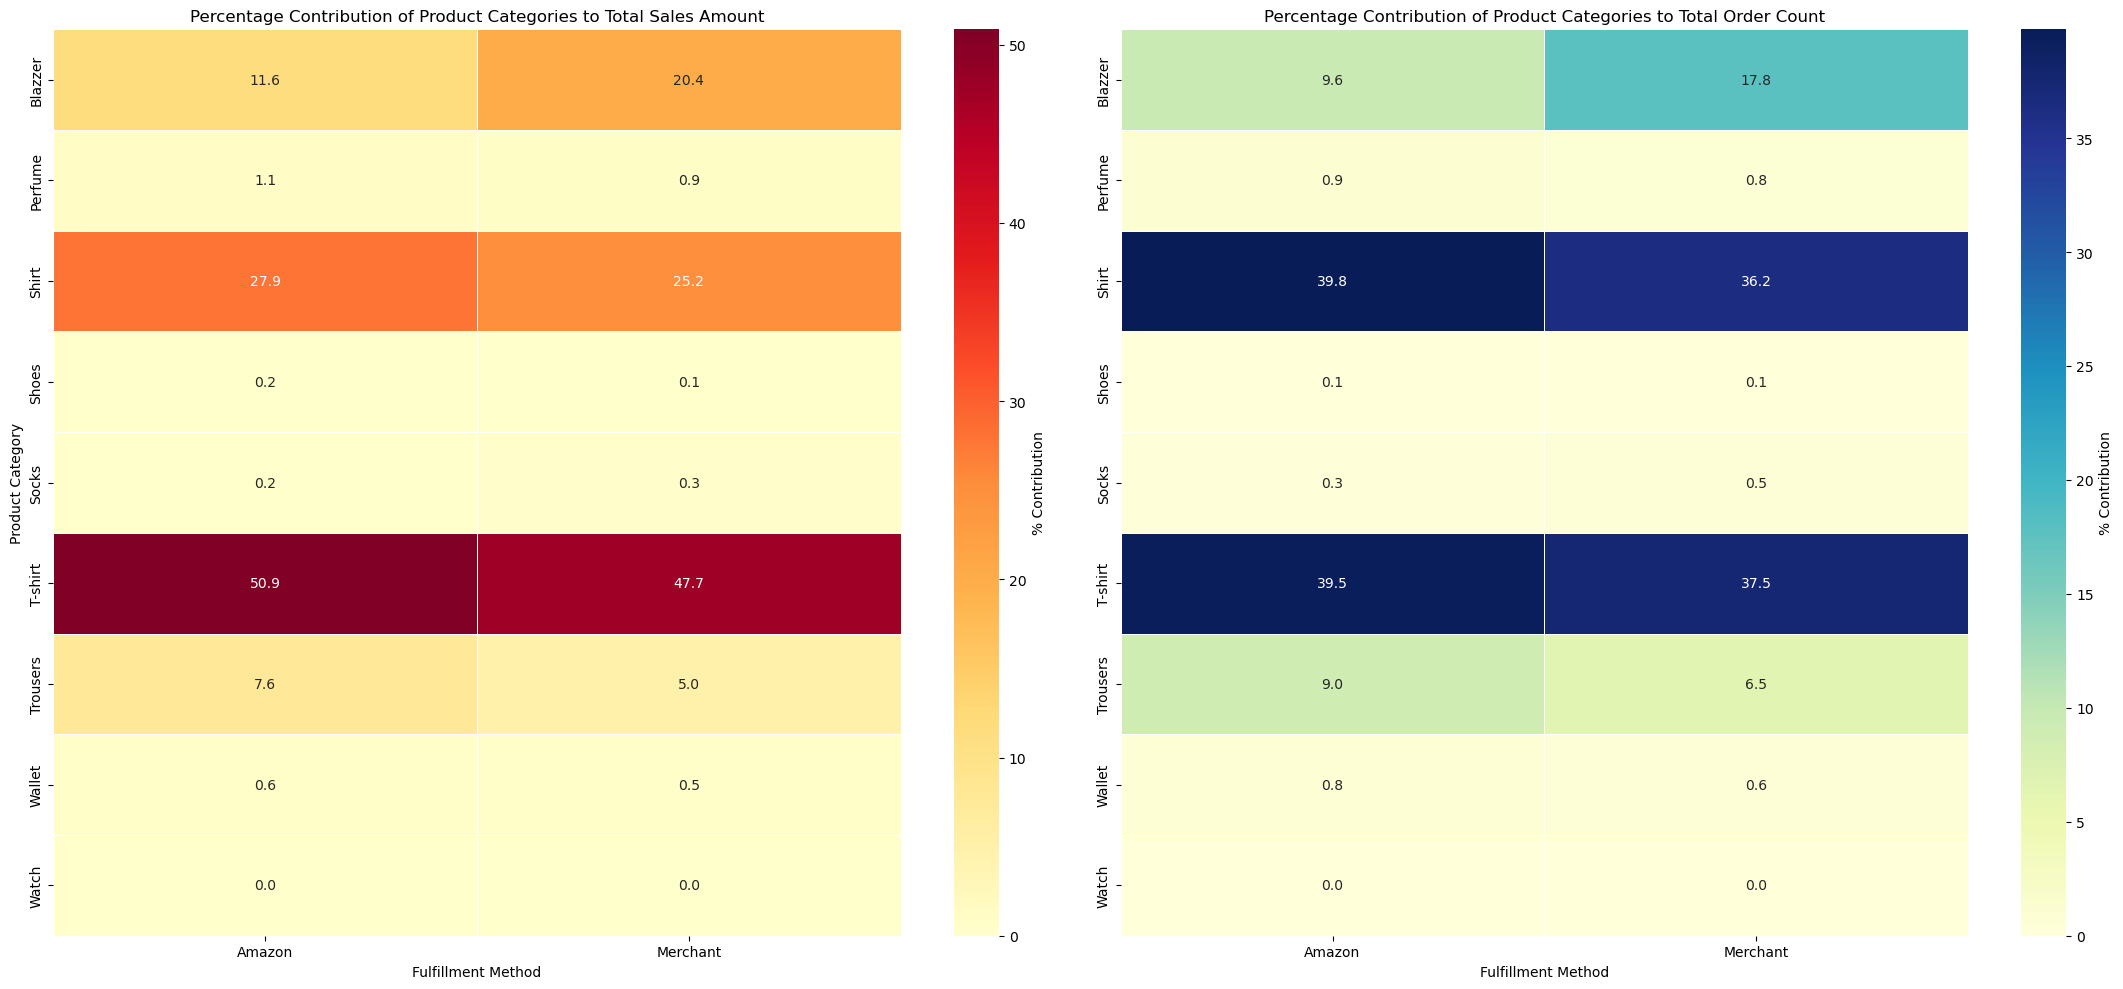

In [20]:
heatmap_data = df.pivot_table(index='Category', columns='Fulfilment', values='Amount', aggfunc='sum').fillna(0)

percent_contribution_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

order_count_data = df.pivot_table(index='Category', columns='Fulfilment', values='Qty', aggfunc='count').fillna(0)

percent_order_count_data = order_count_data.div(order_count_data.sum(axis=0), axis=1) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(percent_contribution_data, annot=True, cmap='YlOrRd', linewidths=.5, fmt='.1f', cbar_kws={'label': '% Contribution'}, ax=ax1)
ax1.set_title('Percentage Contribution of Product Categories to Total Sales Amount')
ax1.set_xlabel('Fulfillment Method')
ax1.set_ylabel('Product Category')

sns.heatmap(percent_order_count_data, annot=True, cmap='YlGnBu', linewidths=.5, fmt='.1f', cbar_kws={'label': '% Contribution'}, ax=ax2)
ax2.set_title('Percentage Contribution of Product Categories to Total Order Count')
ax2.set_xlabel('Fulfillment Method')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

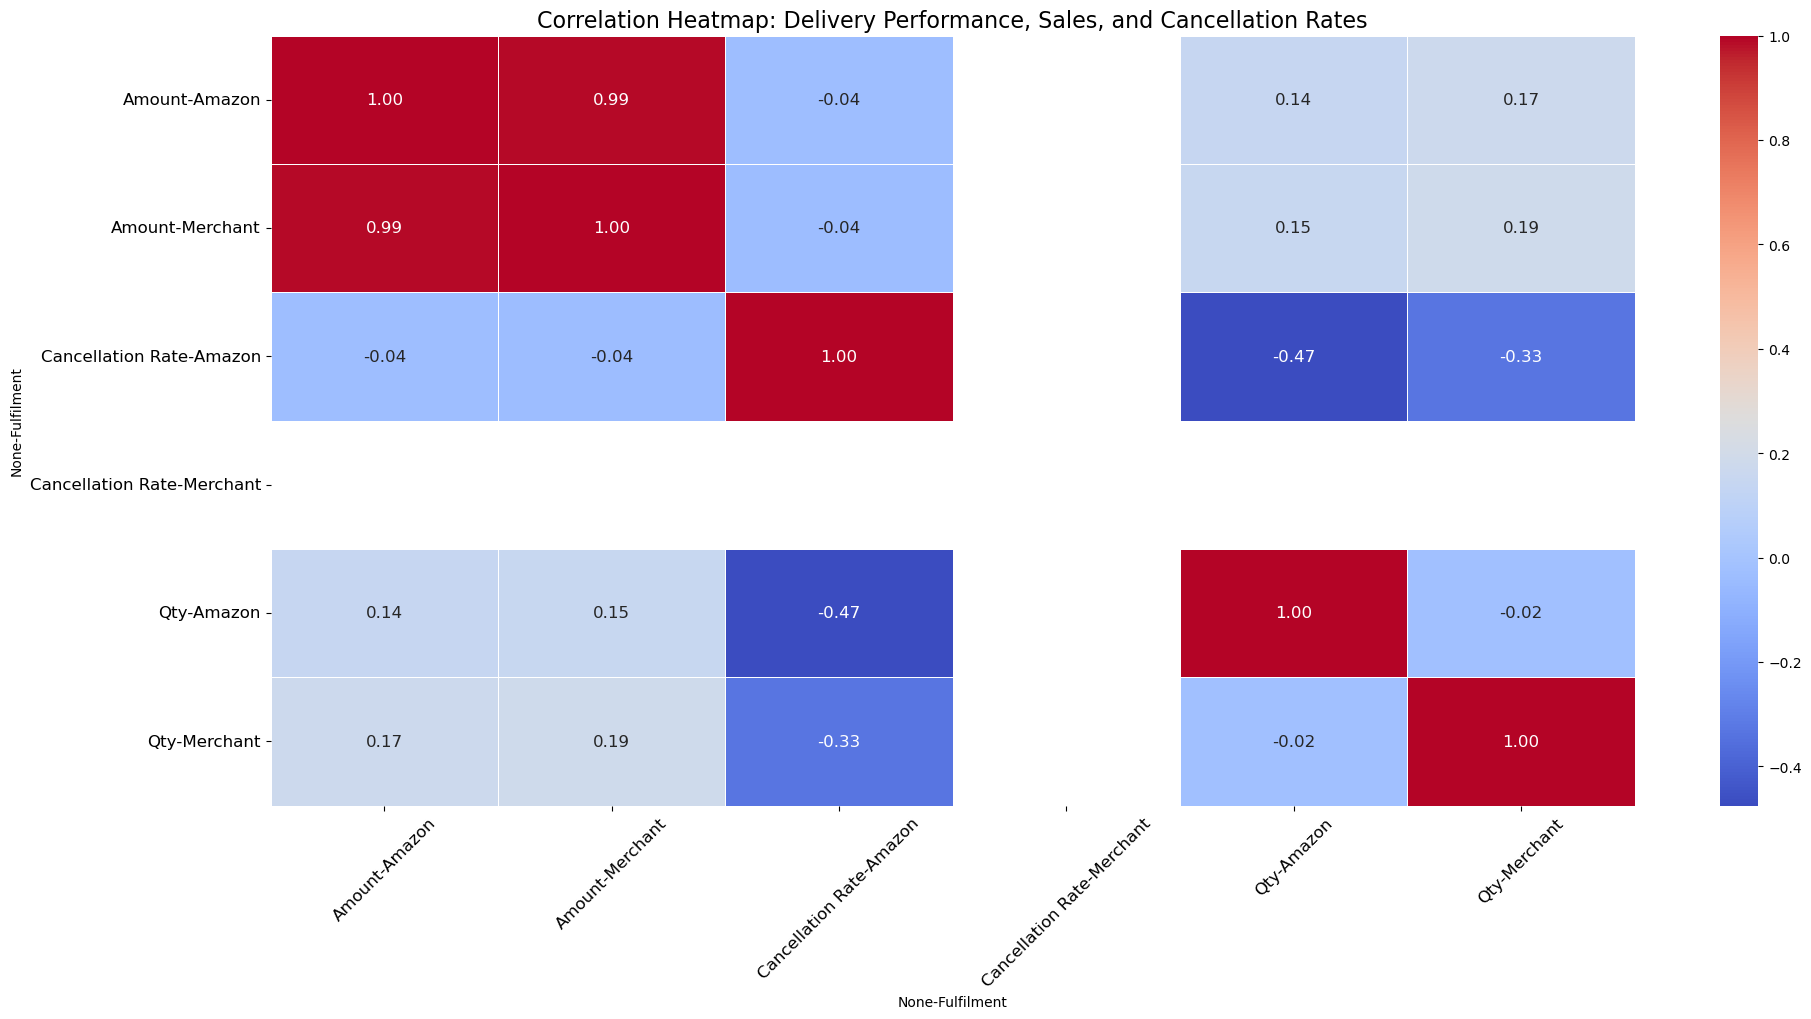

In [24]:
df['Cancelled'] = df['Courier Status'] == 'Cancelled'
total_orders = df.groupby(['ship-state', 'Category', 'Fulfilment'])['Qty'].count().reset_index(name='Total Orders')
cancelled_orders = df[df['Cancelled']].groupby(['ship-state', 'Category', 'Fulfilment'])['Qty'].count().reset_index(name='Cancelled Orders')
cancellation_rate_data = pd.merge(total_orders, cancelled_orders, on=['ship-state', 'Category', 'Fulfilment'], how='left')
cancellation_rate_data['Cancelled Orders'] = cancellation_rate_data['Cancelled Orders'].fillna(0)
cancellation_rate_data['Cancellation Rate'] = cancellation_rate_data['Cancelled Orders'] / cancellation_rate_data['Total Orders']
data = pd.merge(df, cancellation_rate_data[['ship-state', 'Category', 'Fulfilment', 'Cancellation Rate']], on=['ship-state', 'Category', 'Fulfilment'], how='left')

delivery_data = data.groupby(['ship-state', 'Category', 'Fulfilment']).agg({
    'Cancellation Rate': 'mean',
    'Qty': 'mean',
    'Amount': 'sum'
}).reset_index()

pivot_delivery_data = delivery_data.pivot_table(index='ship-state', columns='Fulfilment', values=['Cancellation Rate', 'Qty', 'Amount']).fillna(0)

correlation_matrix = pivot_delivery_data.corr()

plt.figure(figsize=(22, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 12})  # Increase annotation font size
plt.title('Correlation Heatmap: Delivery Performance, Sales, and Cancellation Rates', fontsize=16)  # Increase title font size
plt.xticks(rotation=45, fontsize=12)  # Tilt x-axis labels by 45 degrees and increase font size
plt.yticks(fontsize=12)  # Increase y-axis labels font size
plt.show()

- Amazon Fulfillment: Stronger negative correlation (-0.475). Lower cancellation rates are strongly associated with higher order quantities, indicating that reducing cancellations can lead to larger order sizes.

- Merchant Fulfillment: Moderate negative correlation (-0.333). Though less pronounced than Amazon, reducing cancellations still positively affects order sizes.

- For both Amazon (0.142) and Merchant (0.185) fulfillment methods, there is a positive correlation, showing that as order quantities increase, total sales amounts also rise, reinforcing the importance of encouraging bulk purchases.